In [3]:
import os
import shutil
import numpy as np
import plotly.graph_objects as go
from collections import Counter
from dotenv import load_dotenv
from sklearn.manifold import TSNE
import gradio as gr
import tqdm as notebook_tqdm
# Modern LangChain 0.3 Imports
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader, TextLoader, CSVLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain_core.callbacks import StdOutCallbackHandler

In [4]:
# price is a factor for our company, so we're going to use a low cost model
MODEL = "gpt-4o-mini"
db_name = "vector_Kaiserslautern_db"

In [ ]:
# Load environment variables in a file called .env
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [6]:
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

In [7]:
def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc

documents = []

# Folders to process
folders_to_process = [
    "Data/contacts", 
    "Data/extra", 
    "Data/klausur", 
    "Data/professoren", 
    "Data/Termin", 
    "Data/Vorpraktikum"
]

print(f"Current working directory: {os.getcwd()}")

for folder in folders_to_process:
    if not os.path.exists(folder):
        print(f"Skipping (doesn't exist): {folder}")
        continue
    
    doc_type = os.path.basename(folder)
    print(f"\n{'='*50}\nProcessing folder: {folder} (type: {doc_type})\n{'='*50}")
    
    for root, dirs, files in os.walk(folder):
        if '.ipynb_checkpoints' in root: continue
        for file in files:
            file_path = os.path.join(root, file)
            try:
                if file.endswith('.pdf'):
                    loader = PyPDFLoader(file_path)
                elif file.endswith(('.md', '.txt', '.json')):
                    loader = TextLoader(file_path, encoding='utf-8')
                elif file.endswith('.csv'):
                    loader = CSVLoader(file_path=file_path, encoding='utf-8')
                else: continue
                
                file_docs = loader.load()
                documents.extend([add_metadata(doc, doc_type) for doc in file_docs])
                print(f"  ✓ Loaded {len(file_docs)} units from {file}")
            except Exception as e:
                print(f"  ✗ Error loading {file_path}: {e}")

print(f"\n{'='*50}\nTotal documents loaded: {len(documents)}\n{'='*50}")

# Chunking logic exactly as you had it
if documents:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, 
        chunk_overlap=200,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Total number of chunks: {len(chunks)}")
    
    doc_type_counts = Counter(doc.metadata['doc_type'] for doc in documents)
    chunk_type_counts = Counter(chunk.metadata['doc_type'] for chunk in chunks)
    print(f"\nDocuments per type:")
    for d_type, count in doc_type_counts.items():
        print(f"  - {d_type}: {count} docs → {chunk_type_counts[d_type]} chunks")

Current working directory: D:\projects\llm_engineering\week5\Project_hochschule_kaiserslautern

Processing folder: Data/contacts (type: contacts)
  ✓ Loaded 1 units from pruefungsamt_rag.json

Processing folder: Data/extra (type: extra)
  ✓ Loaded 1 units from Deutschland-Semesterticket.md

Processing folder: Data/klausur (type: klausur)
  ✓ Loaded 3 units from Pruefungsplan_PO19.pdf

Processing folder: Data/professoren (type: professoren)
  ✓ Loaded 1 units from Albert Meij.md
  ✓ Loaded 1 units from Andreas Steil.md
  ✓ Loaded 1 units from arl-Heinz Helmstädter.md
  ✓ Loaded 1 units from Christian M. Thurnes.md
  ✓ Loaded 1 units from Christian Schumann.md
  ✓ Loaded 1 units from Constantin Bauer.md
  ✓ Loaded 1 units from Dirk Enk.md
  ✓ Loaded 1 units from Eva Maria Kiss.md
  ✓ Loaded 1 units from Felix Möhrle.md
  ✓ Loaded 1 units from Felix Wick.md
  ✓ Loaded 1 units from Frank Bomarius.md
  ✓ Loaded 1 units from Gerd Bitsch.md
  ✓ Loaded 1 units from habil. Peter Starke.md
  ✓ L

In [8]:
# ///////////
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: Termin, Vorpraktikum, professoren, extra, contacts, klausur


In [ ]:
# ///////////
for chunk in chunks:
    if 'Steffen' in chunk.page_content:  #Lancaster / Avery
        print(chunk)
        print("_________")

In [10]:
# ///////////
len(documents)

52

In [11]:
# ///////////
documents[30]

Document(metadata={'source': 'Data/professoren\\Norbert Gilbert.md', 'doc_type': 'professoren'}, page_content='# Prof. Dr.-Ing. Norbert Gilbert\n\n**Campus:** Kaiserslautern  \n**Raum:** F1.029  \n**Telefon:** +49 631 3724-2303, +49 631 3724-2105  \n**E-Mail:** norbert.gilbert(at)hs-kl(dot)de  \n**Fachbereich:** Angewandte Ingenieurwissenschaften  \n\n---\n\n## Lehrgebiete\n- Strömungslehre  \n- Strömungsmaschinen  \n- Computational Fluid Dynamics (CFD)  \n- Experimentalphysik  \n\n## Forschungsgebiete\n- CFD mit OpenSource Programmen (Salome, OpenFOAM, ParaView)  \n- Simulation partikulärer Strömungen mittels DEM (YADE, Liggghts)  \n- Hydrodynamik Vertikaler Windenergieanlagen (VAWT)  \n- Strömungsmesstechnik (LDA, PIV)  \n- Flugzeugvereisung (in-flight icing), BMBF Projekt  \n\n## Sprechstunde\n- Montag 13:00 - 13:50 Uhr und nach Vereinbarung  \n')

In [14]:
if os.path.exists(db_name):
    shutil.rmtree(db_name, ignore_errors=True)
    print(f"Deleted: {db_name}")
else:
    print("Directory does not exist.")

Deleted: vector_Kaiserslautern_db


In [16]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# Delete if already exists
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
collection = vectorstore._collection
print(f"Vectorstore created with {collection.count()} documents")

Vectorstore created with 173 documents


In [17]:
# Let's investigate the vectors ///////////

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 173 vectors with 1,536 dimensions in the vector store


In [32]:
#////////////////////////////
# Visualization Prework
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
v_doc_types = [m['doc_type'] for m in metadatas]

#  Define all types and their colors (added 'Vorpraktikum')
type_color_map = {
    'contacts': 'blue',
    'Termin': 'green',
    'klausur': 'red',
    'professoren': 'orange',
    'extra': 'yellow',
    'Vorpraktikum': 'purple'
}

#  Assign colors safely
colors = [type_color_map.get(t, 'gray') for t in doc_types]


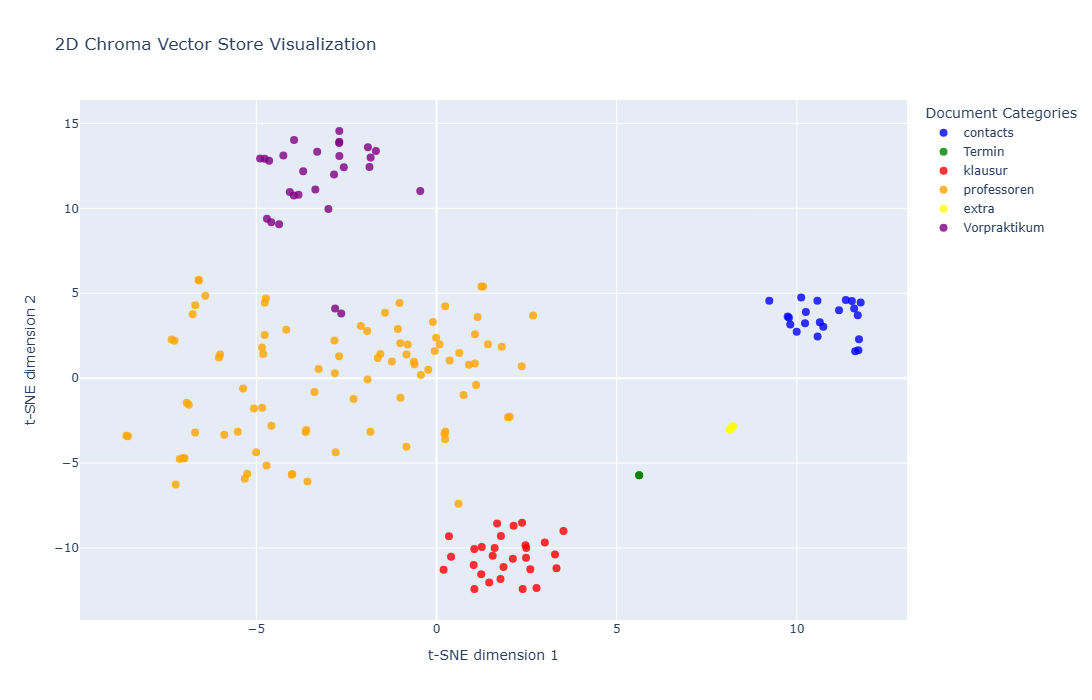

In [41]:
# 2D t-SNE Visualization
tsne_2d = TSNE(n_components=2, random_state=42)
reduced_vectors_2d = tsne_2d.fit_transform(vectors)

fig_2d = go.Figure()

for doc_type, color in type_color_map.items():
    # Match the indices from our vector list
    indices = [i for i, t in enumerate(v_doc_types) if t == doc_type]
    
    if not indices:
        continue
        
    fig_2d.add_trace(go.Scatter(
        x=reduced_vectors_2d[indices, 0],
        y=reduced_vectors_2d[indices, 1],
        mode='markers',
        marker=dict(size=8, color=color, opacity=0.8),
        name= doc_type,
        # v_docs contains the raw text strings we pulled from Chroma
        text=[f"Type: {doc_type}<br>Text: {v_docs[i][:150]}..." for i in indices],
        hoverinfo='text'
    ))

fig_2d.update_layout(
    title='2D Chroma Vector Store Visualization',
    xaxis_title='t-SNE dimension 1',
    yaxis_title='t-SNE dimension 2',
    width=900,
    height=700,
    legend_title_text='Document Categories'
)

fig_2d.show()

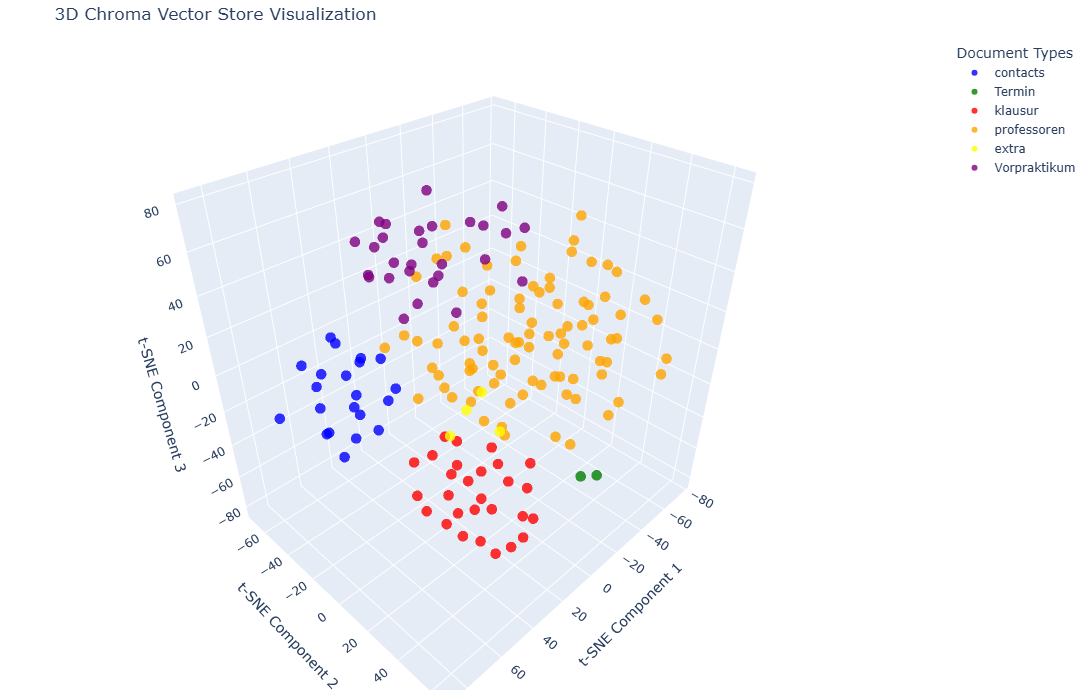

In [42]:
# Let's try 3D!
tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

fig_3d = go.Figure()
for doc_type, color in type_color_map.items():
    indices = [i for i, t in enumerate(v_doc_types) if t == doc_type]
    if not indices:
        continue
    fig_3d.add_trace(go.Scatter3d(
        x=reduced_vectors[indices, 0],
        y=reduced_vectors[indices, 1],
        z=reduced_vectors[indices, 2],
        mode='markers',
        marker=dict(size=6, color=color, opacity=0.8),
        name=doc_type,
        # Using v_docs[i] to ensure we only get the text snippet
        text=[f"Type: {doc_type}<br>Text: {v_docs[i][:100]}..." for i in indices],
        hoverinfo='text'
    ))

fig_3d.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(
        xaxis_title='t-SNE Component 1',
        yaxis_title='t-SNE Component 2',
        zaxis_title='t-SNE Component 3'
    ),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40),
    legend_title_text='Document Types'
)

In [52]:
#/////// exemmple before deploying into the gradio UI

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

conversation_chain = ConversationalRetrievalChain.from_llm(
    llm=llm, 
    retriever=retriever, 
    memory=memory, 
### here we add the Every time the chain invokes the LLM or does something, you’ll see logging information printed in your console.
###This is especially helpful during development to understand what the model is doing, how retrieval is working, or if there are any issues.
    callbacks=[StdOutCallbackHandler()]
)

query = "welche raum und wann wird den klausur aktor und sensor von PO2019 ?"
result = conversation_chain.invoke({"question": query})
print("\nAnswer:", result["answer"])



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
Prüfungsplan für das WiSe 2025/2026 des Fachbereichs AINGStand: 09.10.2025
alle Bachelor-Studiengänge (PO 2019)
Master-Studiengang ET/IT (PO 2021)
BasisD BasisDBasisD Rech Zuweis BasisD Zuweis Rech BasisD BasisD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD Rech Fixe VorgabeRech Rech
Lehrgebiet
ArtPNR Tag Prüfungsdatum Dauer Prüfer/-in Zweitprüfer/-in (gem. 
ABPO, §8)
ET-ATET-ATITET-ENEIMB-AddMB-AMMB-DPEMB-EngMB-LKMB-PTMB-VTMTWI-ABWI-AddWI-EngWI-ENWI-MBWI-PTWI-RE
Aktor- und Sensortechnik Ba 1827 Mo 26.01.2026 90 min 11:00 12:30 Geromiller Urschel 4 - 4 - - - - - - - - - - - - - - - - Do 20.11.2025 Mo 19.01.2026
Aktorik und Sensorik Ba 1

In [ ]:
# Memory for context-aware chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# Create the chain
conversation_chain = ConversationalRetrievalChain.from_llm(
    llm=llm, 
    retriever=retriever, 
    memory=memory,
    callbacks=[StdOutCallbackHandler()] # This shows you the logic in the terminal
)

def chat_function(message, history):
    # Gradio sends 'message' as a dict or string depending on version
    query = message["text"] if isinstance(message, dict) else message
    result = conversation_chain.invoke({"question": query})
    return result["answer"]

# Launch the UI
demo = gr.ChatInterface(
    fn=chat_function, 
    title="Kaiserslautern University Assistant",
    fill_height=True,   # make chat expand vertically
)

demo.launch(inbrowser=True, share=True)

* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://7cc1dab393e7dd476c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
Prüfungsplan für das WiSe 2025/2026 des Fachbereichs AINGStand: 09.10.2025
alle Bachelor-Studiengänge (PO 2019)
Master-Studiengang ET/IT (PO 2021)
BasisD BasisDBasisD Rech Zuweis BasisD Zuweis Rech BasisD BasisD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD Rech Fixe VorgabeRech Rech
Lehrgebiet
ArtPNR Tag Prüfungsdatum Dau

In [ ]:
#When is the aktor und Sensortechnik exam?
#what project is professor Urschel working on ?
